In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


In [3]:
#!unzip /content/drive/MyDrive/image_tampering_detection/CASIA2_DATA.zip -d /content/drive/MyDrive/image_tampering_detection/

In [4]:
import os
import io
import cv2
import random
import itertools
import numpy as np
from pylab import *
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
import efficientnet.keras as effnet
from keras.applications.vgg19 import VGG19
from keras.utils import to_categorical
from PIL import Image, ImageChops, ImageEnhance
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.applications.densenet import DenseNet201
from sklearn.metrics import confusion_matrix,classification_report
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import BatchNormalization, AveragePooling2D, GlobalAveragePooling2D

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def image_loading(path, quality):
    image = Image.open(path).convert('RGB')
    return image

In [7]:
#data loading
labels = ['Au', 'Tp']
image_size=128
X = []
Y = []

for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/image_tampering_detection/CASIA2_DATA',label)
    for file in tqdm(os.listdir(trainPath)[:3000]):
        X.append(array(image_loading(os.path.join(trainPath, file), 90).resize((128, 128))).flatten() / 255.0)
        Y.append(label)

X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

100%|██████████| 3000/3000 [03:38<00:00, 13.75it/s]


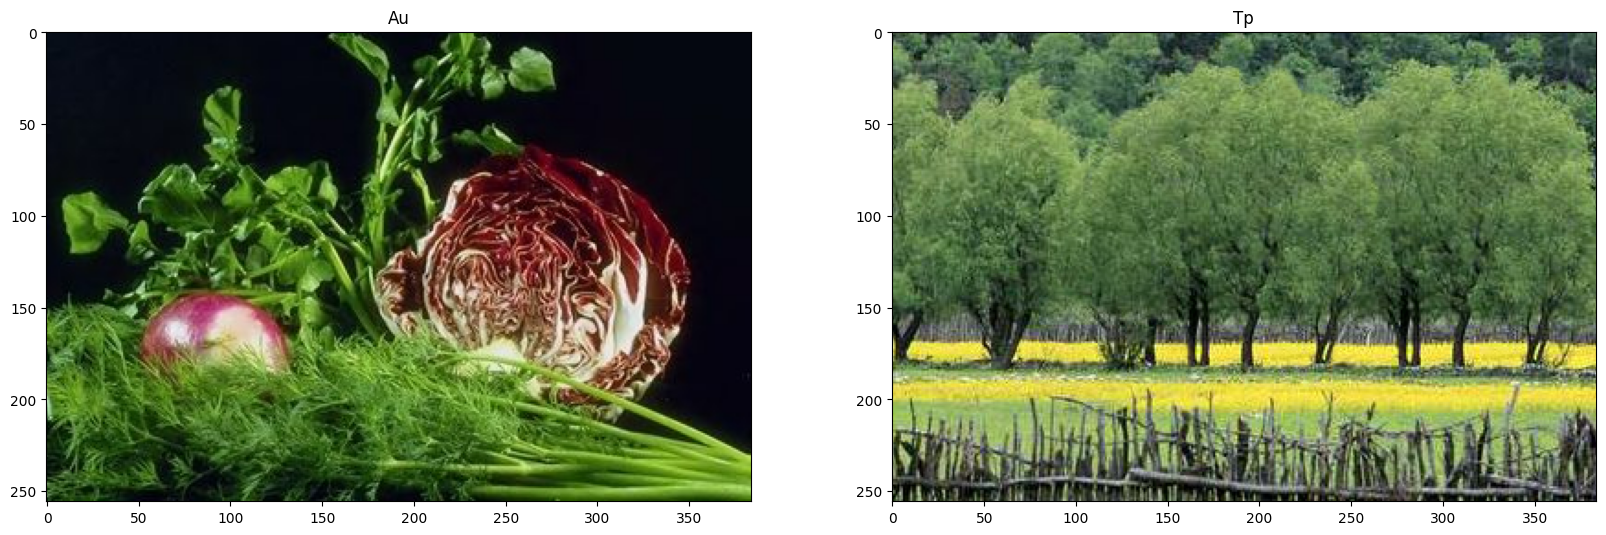

In [8]:

#Data Visualization
import matplotlib.image as mpimg
plt.figure(figsize = (20, 40))
image_count = 1
BASE_URL = '/content/drive/MyDrive/image_tampering_detection/CASIA2_DATA/'
for directory in labels:
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory)

<Axes: ylabel='count'>

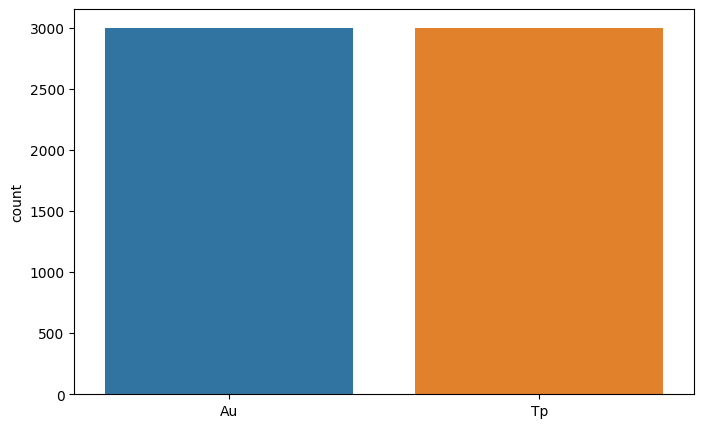

In [9]:
#count plot
plt.figure(figsize = (8, 5))
plt.xticks(rotation=0)
sns.countplot(x=Y,palette=sns.color_palette())

In [10]:
#converting categorical class to number
y = []
for i in Y:
  if i == 'Tp':
    y.append(1)
  else:
    y.append(0)

Y = y
Y = to_categorical(Y, 2)

In [11]:
print("shape of image: ",X.shape)
print("shape of target class: ",Y.shape)

shape of image:  (6000, 128, 128, 3)
shape of target class:  (6000, 2)


In [12]:
#splitting data into train and test with ratio of 80:10:10
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=5, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=5, shuffle=True)

#EfficientNet-B2

In [13]:
epochs = 10
batch_size = 20

In [14]:
base_model = effnet.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(2, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

31936256/31936256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 64, 64, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  

In [15]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
243/243 [==============================] - 83s 104ms/step - loss: 0.6465 - accuracy: 0.6751 - val_loss: 0.6393 - val_accuracy: 0.6981
Epoch 2/10
243/243 [==============================] - 21s 86ms/step - loss: 0.4963 - accuracy: 0.7675 - val_loss: 0.5250 - val_accuracy: 0.7444
Epoch 3/10
243/243 [==============================] - 22s 90ms/step - loss: 0.4418 - accuracy: 0.8070 - val_loss: 0.6658 - val_accuracy: 0.7000
Epoch 4/10
243/243 [==============================] - 22s 90ms/step - loss: 0.4227 - accuracy: 0.8146 - val_loss: 1.5066 - val_accuracy: 0.6500
Epoch 5/10
243/243 [==============================] - 22s 89ms/step - loss: 0.3740 - accuracy: 0.8434 - val_loss: 0.5013 - val_accuracy: 0.7815
Epoch 6/10
243/243 [==============================] - 22s 90ms/step - loss: 0.3424 - accuracy: 0.8453 - val_loss: 0.9322 - val_accuracy: 0.6204
Epoch 7/10
243/243 [==============================] - 22s 90ms/step - loss: 0.3472 - accuracy: 0.8459 - val_loss: 0.5544 - val_accuracy

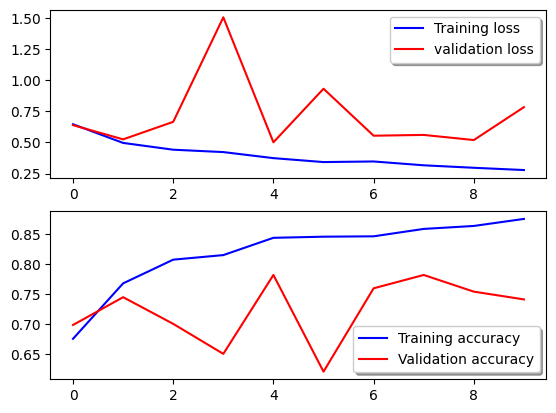

In [16]:
#Accuracy & Loss Graph
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
legend_ = ax[1].legend(loc='best', shadow=True)

In [17]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

19/19 [==============================] - 5s 95ms/step


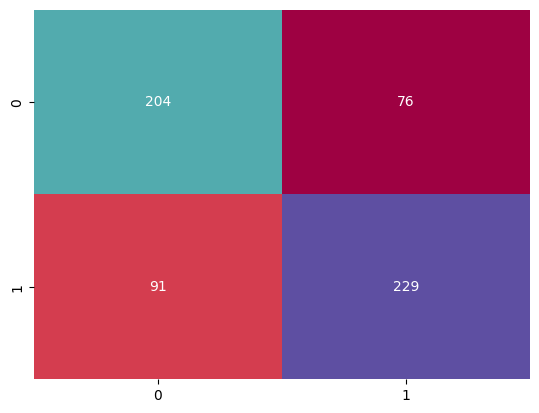

In [18]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
#plt.figure(figsize=(10,10))
sns.heatmap(confusion_mtx, annot = True, cbar = False, cmap=cm.get_cmap("Spectral"), fmt="d");

In [19]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       280
           1       0.75      0.72      0.73       320

    accuracy                           0.72       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.72      0.72      0.72       600

